In [ ]:
# Real F1 telemetry -> track_data.csv using FastF1
# - Change YEAR, EVENT, SESSION, DRIVER, N_SEGMENTS as needed
# - Produces columns: length_m, baseline_speed_kph, is_braking_zone, is_drs_zone

import sys
import subprocess

# Ensure FastF1 is available
try:
    import fastf1  # type: ignore
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fastf1", "--quiet"])  # non-interactive install
    import fastf1  # type: ignore

import numpy as np
import pandas as pd

# Cache to avoid repeated downloads
import os
os.makedirs("./fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("./fastf1_cache")

# ----- User parameters -----
YEAR = 2024           # e.g., 2023, 2024
EVENT = "Monza"       # e.g., "Monza", "Bahrain", "Silverstone" (event name)
SESSION = "R"         # "FP1", "FP2", "FP3", "Q", "SQ", "R"
DRIVER = "None"        # 3-letter code, or set to None to use session fastest lap
N_SEGMENTS = 10       # number of segments to aggregate telemetry into

# ---------------------------
print(f"Loading {YEAR} {EVENT} {SESSION} telemetry...")
session = fastf1.get_session(YEAR, EVENT, SESSION)
session.load()

if DRIVER:
    laps = session.laps.pick_drivers(DRIVER)
    if len(laps) == 0:
        raise RuntimeError(f"No laps found for driver {DRIVER} in {YEAR} {EVENT} {SESSION}.")
    lap = laps.pick_fastest()
else:
    lap = session.laps.pick_fastest()

print(f"Using lap: Driver={lap['Driver']}, LapNumber={int(lap['LapNumber'])}, LapTime={lap['LapTime']}")

# Telemetry: Distance [m], Speed [km/h], Brake [bool], DRS [int]
telemetry = lap.get_telemetry()
telemetry = telemetry.dropna(subset=["Distance", "Speed"]).copy()

# Normalize and clean channels used below
distance_m = telemetry["Distance"].to_numpy()
speed_kph = telemetry["Speed"].to_numpy()
# Brake is sometimes float/bool; coerce to {0,1}
brake_flag = telemetry.get("Brake")
if brake_flag is None:
    # Approximate braking via negative longitudinal acceleration if Brake not present
    # Compute delta-v over delta-t; FastF1 Time is Timedelta -> seconds
    t_s = telemetry["Time"].dt.total_seconds().to_numpy()
    # Add small epsilon to avoid division by zero
    dv = np.diff(speed_kph, prepend=speed_kph[0])
    dt = np.diff(t_s, prepend=t_s[0]) + 1e-6
    decel = (dv / dt) < -2.0  # km/h per s threshold
    brake_flag = pd.Series(decel.astype(int), index=telemetry.index)
else:
    brake_flag = brake_flag.astype(int)

# DRS channel: treat values >= 10 as active (per FastF1 docs/convention)
drs_raw = telemetry.get("DRS")
if drs_raw is None:
    drs_raw = pd.Series(np.zeros(len(telemetry), dtype=int), index=telemetry.index)
else:
    drs_raw = drs_raw.fillna(0).astype(int)

drs_active = (drs_raw >= 10).astype(int).to_numpy()

# Segment the lap by distance into N equal bins
edges = np.linspace(distance_m.min(), distance_m.max(), N_SEGMENTS + 1)
rows = []
for i in range(N_SEGMENTS):
    left, right = edges[i], edges[i + 1]
    mask = (distance_m >= left) & (distance_m < right) if i < N_SEGMENTS - 1 else (distance_m >= left) & (distance_m <= right)

    if not np.any(mask):
        # Fallback: create a tiny placeholder segment with previous speed
        length_m = float(right - left)
        baseline_speed = float(max(1.0, speed_kph[max(0, np.argmax(distance_m >= left) - 1)]))
        rows.append({
            "length_m": length_m,
            "baseline_speed_kph": baseline_speed,
            "is_braking_zone": 0,
            "is_drs_zone": 0,
        })
        continue

    seg_len = float(right - left)
    seg_speed = float(max(1.0, np.nanmean(speed_kph[mask])))
    seg_brake = int(np.nanmean(brake_flag.to_numpy()[mask]) > 0.2)
    seg_drs = int(np.nanmean(drs_active[mask]) > 0.3)

    rows.append({
        "length_m": seg_len,
        "baseline_speed_kph": seg_speed,
        "is_braking_zone": seg_brake,
        "is_drs_zone": seg_drs,
    })

track_df = pd.DataFrame(rows)
# Basic sanity
track_df["length_m"] = track_df["length_m"].clip(lower=0.1)
track_df["baseline_speed_kph"] = track_df["baseline_speed_kph"].clip(lower=1.0)

track_df.to_csv("track_data.csv", index=False)
print(f"Saved track_data.csv with {len(track_df)} segments.")
print(track_df.head(3))


Loading 2024 Monza R telemetry...


core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

Using lap: Driver=VER, LapNumber=43, LapTime=0 days 00:01:21.745000
Saved track_data.csv with 10 segments.
     length_m  baseline_speed_kph  is_braking_zone  is_drs_zone
0  575.383833          327.841608                0            0
1  575.383833          178.716025                1            0
2  575.383833          289.633093                0            0


Track loaded with 10 segments.
Starting AI optimization for WET conditions (DRS: True)...
(This may take a few minutes)
 The best solution found:                                                                           
 [2. 1. 0. 1. 1. 0. 1. 0. 0. 1.]

 Objective function:
 93.4851553899461


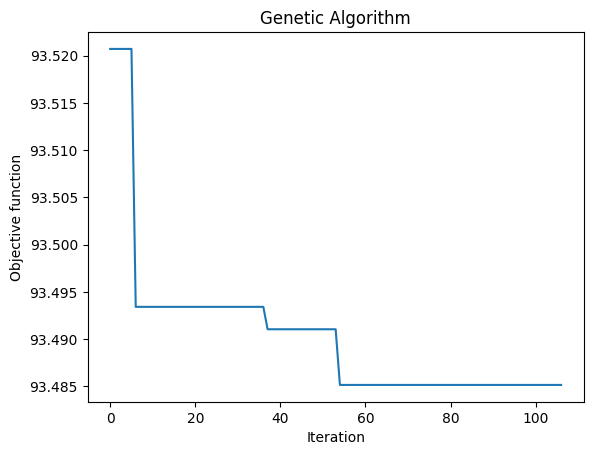


--- 🏁 AI Optimization Complete! ---
Conditions: WET (DRS: True)
Fastest Lap Time Found: 93.485 seconds

Best Strategy:
['HARVEST', 'DEPLOY', 'COAST', 'DEPLOY', 'DEPLOY', 'COAST', 'DEPLOY', 'COAST', 'COAST', 'DEPLOY']

Generating lap visualization...
Saved visualization to 'optimal_lap.png'


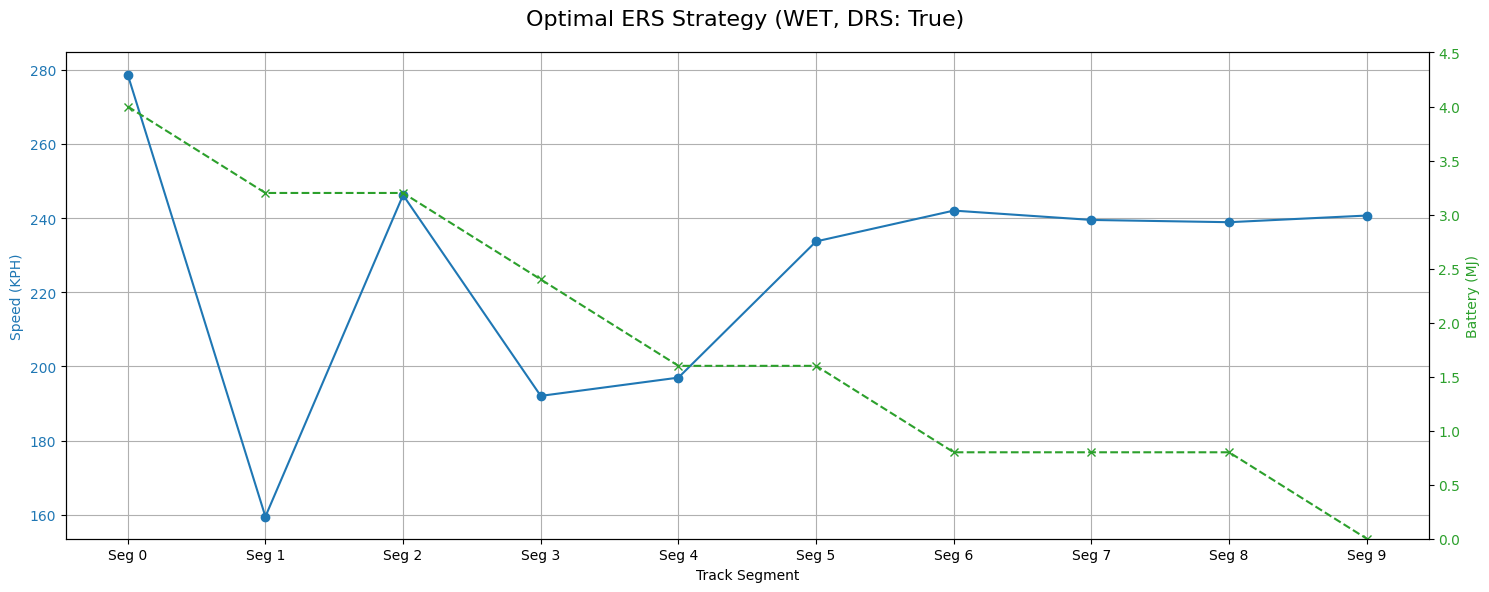

In [3]:
import pandas as pd
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

# --- 1. DEFINE YOUR "WORLD" CONSTANTS ---

# --- NEW: SET REAL-WORLD CONDITIONS ---
# Change these values to see how the AI's strategy changes
TRACK_CONDITION = 'WET' # Change to 'WET' to see the difference
DRS_ENABLED = True      # Change to False if DRS is not allowed

# ERS Actions (Our "Genes")
# 0 = COAST, 1 = DEPLOY, 2 = HARVEST
ACTION_COAST = 0
ACTION_DEPLOY = 1
ACTION_HARVEST = 2

# Car/Rules Constants
MAX_BATTERY_MJ = 4.0       # Max capacity
MAX_DEPLOY_PER_LAP_MJ = 4.0  # Max you can USE in one lap
MAX_HARVEST_PER_LAP_MJ = 2.0 # Max you can GAIN in one lap

# --- 2. Load the Track Data ---
try:
    track_df = pd.read_csv('track_data.csv')
    NUM_SEGMENTS = len(track_df)
    print(f"Track loaded with {NUM_SEGMENTS} segments.")
except FileNotFoundError:
    print("Error: 'track_data.csv' not found. Make sure it's in the same folder.")
    exit()
except KeyError:
    print("Error: Your 'track_data.csv' is missing a required column.")
    print("Please make sure it has: 'is_drs_zone'")
    exit()


# --- 3. Build the Simulator (The "Fitness Function") ---
# This version now accepts modifiers for real-world conditions
def calculate_lap_time(strategy, grip_modifier=1.0, drs_boost=1.0, harvest_efficiency=1.0):
    
    total_time_sec = 0
    current_battery_mj = MAX_BATTERY_MJ
    total_deployed_mj = 0
    total_harvested_mj = 0

    # Simplified physics
    DEPLOY_BOOST_PERCENT = 1.05
    HARVEST_BRAKE_PERCENT = 0.85
    
    ENERGY_COST_PER_DEPLOY_MJ = MAX_DEPLOY_PER_LAP_MJ / (NUM_SEGMENTS / 2)
    ENERGY_GAIN_PER_HARVEST_MJ = MAX_HARVEST_PER_LAP_MJ / (NUM_SEGMENTS / 4)

    for i in range(NUM_SEGMENTS):
        segment = track_df.iloc[i]
        decision = strategy[i]
        
        # --- Start with baseline speed ---
        speed_kph = segment['baseline_speed_kph']
        
        # --- APPLY REAL-WORLD CONDITIONS ---
        # 1. Apply Grip (Rain)
        speed_kph *= grip_modifier
        
        # 2. Apply DRS
        if segment['is_drs_zone'] == 1 and drs_boost > 1.0:
            speed_kph *= drs_boost

        # --- APPLY AI DECISION (on top of the new baseline) ---
        if decision == ACTION_DEPLOY:
            if current_battery_mj > ENERGY_COST_PER_DEPLOY_MJ and total_deployed_mj < MAX_DEPLOY_PER_LAP_MJ:
                speed_kph *= DEPLOY_BOOST_PERCENT
                current_battery_mj -= ENERGY_COST_PER_DEPLOY_MJ
                total_deployed_mj += ENERGY_COST_PER_DEPLOY_MJ
            
        elif decision == ACTION_HARVEST:
            if segment['is_braking_zone'] == 1 and current_battery_mj < MAX_BATTERY_MJ and total_harvested_mj < MAX_HARVEST_PER_LAP_MJ:
                speed_kph *= HARVEST_BRAKE_PERCENT
                
                # Apply harvesting efficiency (less grip = less regen)
                energy_gain = ENERGY_GAIN_PER_HARVEST_MJ * harvest_efficiency 
                
                current_battery_mj = min(MAX_BATTERY_MJ, current_battery_mj + energy_gain)
                total_harvested_mj += energy_gain
        
        # --- Calculate Time ---
        if speed_kph <= 0: # Check for zero or negative speed
            return 99999
            
        speed_mps = speed_kph / 3.6
        time_for_segment_sec = segment['length_m'] / speed_mps
        total_time_sec += time_for_segment_sec

    if total_deployed_mj > MAX_DEPLOY_PER_LAP_MJ or total_harvested_mj > MAX_HARVEST_PER_LAP_MJ:
        return 99999

    return total_time_sec


# --- 4. Setup and Run the AI ---
print(f"Starting AI optimization for {TRACK_CONDITION} conditions (DRS: {DRS_ENABLED})...")
print("(This may take a few minutes)")

# --- Set modifiers based on user input ---
grip_mod = 1.0
harvest_eff = 1.0
drs_mod = 1.0 # 1.0 means "off"

if TRACK_CONDITION == 'WET':
    grip_mod = 0.85      # 15% grip loss
    harvest_eff = 0.7  # 30% less efficient harvesting

if DRS_ENABLED:
    drs_mod = 1.15       # 15% speed boost in DRS zones

# --- Create a wrapper function for the AI ---
# The GA library only accepts a function with ONE argument (strategy).
# We use a 'lambda' function to create a NEW, temporary function
# that has our conditions (grip_mod, drs_mod, etc.) "baked in".
fitness_function_wrapper = lambda s: calculate_lap_time(
    s, 
    grip_modifier=grip_mod, 
    drs_boost=drs_mod, 
    harvest_efficiency=harvest_eff
)

# We need to tell the AI what its "genes" can be
var_boundaries = np.array([[0, 2]] * NUM_SEGMENTS)

# AI parameters
algorithm_param = {
    'max_num_iteration': 500,
    'population_size': 100,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'parents_portion': 0.8, # The fix from before
    'crossover_probability': 0.5,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 50
}

# Create the AI model, passing our NEW wrapper function
model = ga(
    function=fitness_function_wrapper,  # Use the wrapper here
    dimension=NUM_SEGMENTS,
    variable_type='int',
    variable_boundaries=var_boundaries,
    algorithm_parameters=algorithm_param
)

# Run the AI!
model.run()


# --- 5. Get and Display the Results ---
best_strategy = model.best_variable
best_lap_time = model.best_function

print("\n" + "="*40)
print("--- 🏁 AI Optimization Complete! ---")
print(f"Conditions: {TRACK_CONDITION} (DRS: {DRS_ENABLED})")
print(f"Fastest Lap Time Found: {best_lap_time:.3f} seconds")

# Decode the strategy from numbers (0,1,2) to words
strategy_decoded = []
for decision in best_strategy:
    if decision == ACTION_DEPLOY:
        strategy_decoded.append("DEPLOY")
    elif decision == ACTION_HARVEST:
        strategy_decoded.append("HARVEST")
    else:
        strategy_decoded.append("COAST")

print("\nBest Strategy:")
print(strategy_decoded)
print("="*40)


# --- 6. Visualize the Winning Lap ---
# We must re-run the simulation with the best strategy to log the data
print("\nGenerating lap visualization...")

# Lists to store telemetry
l_speed_kph = []
l_battery_mj = []

# --- Re-run the simulator using the best strategy AND same conditions ---
current_battery_mj = MAX_BATTERY_MJ
total_deployed_mj = 0
total_harvested_mj = 0

# (Need to redefine these constants inside this section for this re-run)
DEPLOY_BOOST_PERCENT = 1.05
HARVEST_BRAKE_PERCENT = 0.85
ENERGY_COST_PER_DEPLOY_MJ = MAX_DEPLOY_PER_LAP_MJ / (NUM_SEGMENTS / 2)
ENERGY_GAIN_PER_HARVEST_MJ = MAX_HARVEST_PER_LAP_MJ / (NUM_SEGMENTS / 4)

# (Must re-apply the *exact same conditions* as the simulation)
grip_mod = 1.0
harvest_eff = 1.0
drs_mod = 1.0
if TRACK_CONDITION == 'WET':
    grip_mod = 0.85
    harvest_eff = 0.7
if DRS_ENABLED:
    drs_mod = 1.15

for i in range(NUM_SEGMENTS):
    segment = track_df.iloc[i]
    decision = best_strategy[i]
    
    speed_kph = segment['baseline_speed_kph']
    
    # Apply conditions
    speed_kph *= grip_mod
    if segment['is_drs_zone'] == 1 and drs_mod > 1.0:
        speed_kph *= drs_mod
    
    if decision == ACTION_DEPLOY:
        if current_battery_mj > ENERGY_COST_PER_DEPLOY_MJ and total_deployed_mj < MAX_DEPLOY_PER_LAP_MJ:
            speed_kph *= DEPLOY_BOOST_PERCENT
            current_battery_mj -= ENERGY_COST_PER_DEPLOY_MJ
            total_deployed_mj += ENERGY_COST_PER_DEPLOY_MJ
            
    elif decision == ACTION_HARVEST:
        if segment['is_braking_zone'] == 1 and current_battery_mj < MAX_BATTERY_MJ and total_harvested_mj < MAX_HARVEST_PER_LAP_MJ:
            speed_kph *= HARVEST_BRAKE_PERCENT
            energy_gain = ENERGY_GAIN_PER_HARVEST_MJ * harvest_eff
            current_battery_mj = min(MAX_BATTERY_MJ, current_battery_mj + energy_gain)
            total_harvested_mj += energy_gain

    # Log the data for this segment
    l_speed_kph.append(speed_kph)
    l_battery_mj.append(current_battery_mj)

# --- Create the Plot ---
segment_labels = [f"Seg {i}" for i in range(NUM_SEGMENTS)]

fig, ax1 = plt.subplots(figsize=(15, 6)) # Make the graph wider

# Plot 1: Speed (Left Y-axis)
color = 'tab:blue'
ax1.set_xlabel('Track Segment')
ax1.set_ylabel('Speed (KPH)', color=color)
ax1.plot(segment_labels, l_speed_kph, color=color, marker='o', label='Speed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot 2: Battery (Right Y-axis)
ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Battery (MJ)', color=color)
ax2.plot(segment_labels, l_battery_mj, color=color, linestyle='--', marker='x', label='Battery')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, MAX_BATTERY_MJ + 0.5) # Set fixed battery scale

fig.suptitle(f'Optimal ERS Strategy ({TRACK_CONDITION}, DRS: {DRS_ENABLED})', fontsize=16)
fig.tight_layout() # Adjust plot to prevent labels from overlapping

# Save the plot to a file and show it
plt.savefig('optimal_lap.png')
print("Saved visualization to 'optimal_lap.png'")
plt.show()